In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [6]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras


In [7]:
setting = "setting1"
hs = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]

[0.2, 0.4, 0.6, 0.8, 1.0, 1.2]

In [8]:
# get results of DDIM and naive
def _add_res(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    dict_res["h"].append(h)
    for ky, v in cur_paras.items():
        dict_res[ky].append(v)
        
our_res = ddict(list)
for h in hs:
    res_dir = RES_ROOT/f"simuLCP_my3{setting}_h{h*100:.0f}";
    all_fils = list(res_dir.glob("*n_T-*.pkl"));
    for fil in all_fils:
        cur_paras = fil_name2paras(fil.stem);
        res = load_pkl(fil, verbose=False);
        
        for ky in res.keys():
            _add_res(res, key=ky, dict_res=our_res)
        
our_res_df = pd.DataFrame(our_res);

In [9]:
# results of CQR and CF
def _add_ores(res, key, dict_res):
    if key not in res.keys():
        return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    dict_res["method"].append(key)
    dict_res["rep"].append(_get_rep(ofil))
_get_rep = lambda p: int(p.stem.split("_")[1])
ofils = list(res_dir.glob("*other*.pkl"));
other_res = ddict(list);
for ofil in ofils:
    res = load_pkl(ofil, verbose=False);
    _add_ores(res, key="CQR", dict_res=other_res)
    _add_ores(res, key="CQR1", dict_res=other_res)
    _add_ores(res, key="CQR2", dict_res=other_res)
    _add_ores(res, key="CQR2c", dict_res=other_res)
other_res_df = pd.DataFrame(other_res);

In [10]:
def _get_dataset(name):
    if name.endswith("1"):
        dat_set = "set1"
    elif name.endswith("2"):
        dat_set = "set2"
    elif name.endswith("2c"):
        dat_set = "set2c"
    else:
        dat_set = "all_data"
    return dat_set

In [11]:
other_res_df["h"] = 0.4
cols = ["rep", "method", "Len", "ITE", "h"]
all_res = pd.concat([our_res_df[cols], other_res_df[cols]]);
all_res["dataset"] = all_res["method"].map(_get_dataset)
all_res["method_raw"] = all_res["method"].map(lambda x: x.split("1")[0].split("2")[0])

In [12]:
datasets = ["all_data", "set1", "set2", "set2c"]
Lmethods =["LDDIM", "LMLP"]
Omethods =["DDIM", "MLP", "CQR"]
cols = ["red", "green", "yellow"];

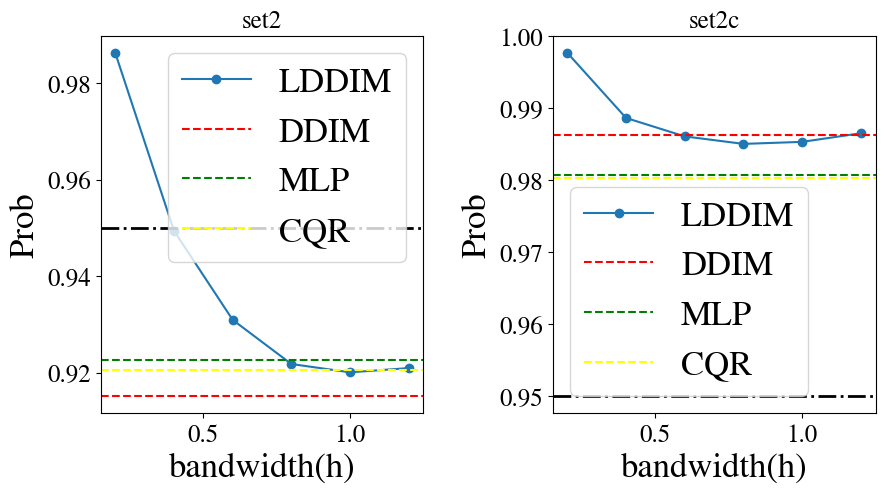

In [13]:

plt.figure(figsize=[10, 5])
dataset = "set2"
plt.subplot(121)
method = "LDDIM"
kpidxs = np.bitwise_and(all_res["method_raw"]==method, all_res["dataset"]==dataset)
foo = all_res[kpidxs].groupby("h").agg(["mean"])
hs = np.array(foo.index)
vs = np.array(foo["ITE"]).reshape(-1)
plt.plot(hs, vs, "o-", label=method)

for col, omethod in zip(cols, Omethods):
    kpidxs = np.bitwise_and(all_res["method_raw"]==omethod, all_res["dataset"]==dataset)
    foo = all_res[kpidxs]
    v = np.mean(foo["ITE"])
    plt.axhline(y=v, ls="--", color=col, label=omethod)
    
plt.axhline(y=0.95, ls="-.", color="black", lw=2)
plt.xlabel("bandwidth(h)")
plt.ylabel("Prob")
plt.title(f"{dataset}")
plt.legend() 

dataset = "set2c"
plt.subplot(122)
method = "LDDIM"
kpidxs = np.bitwise_and(all_res["method_raw"]==method, all_res["dataset"]==dataset)
foo = all_res[kpidxs].groupby("h").agg(["mean"])
hs = np.array(foo.index)
vs = np.array(foo["ITE"]).reshape(-1)
plt.plot(hs, vs, "o-", label=method)

for col, omethod in zip(cols, Omethods):
    kpidxs = np.bitwise_and(all_res["method_raw"]==omethod, all_res["dataset"]==dataset)
    foo = all_res[kpidxs]
    v = np.mean(foo["ITE"])
    plt.axhline(y=v, ls="--", color=col, label=omethod)
    
plt.axhline(y=0.95, ls="-.", color="black", lw=2)
plt.xlabel("bandwidth(h)")
plt.ylabel("Prob")
plt.title(f"{dataset}")
plt.legend() 

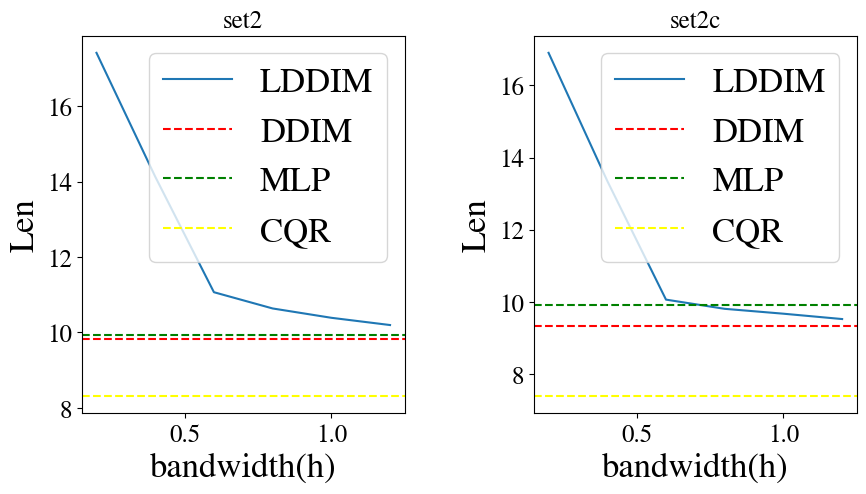

In [14]:

plt.figure(figsize=[10, 5])
dataset = "set2"
plt.subplot(121)
method = "LDDIM"
kpidxs = np.bitwise_and(all_res["method_raw"]==method, all_res["dataset"]==dataset)
foo = all_res[kpidxs].groupby("h").agg(["mean"])
hs = np.array(foo.index)
vs = np.array(foo["Len"]).reshape(-1)
plt.plot(hs, vs, label=method)

for col, omethod in zip(cols, Omethods):
    kpidxs = np.bitwise_and(all_res["method_raw"]==omethod, all_res["dataset"]==dataset)
    foo = all_res[kpidxs]
    v = np.mean(foo["Len"])
    plt.axhline(y=v, ls="--", color=col, label=omethod)
    
plt.xlabel("bandwidth(h)")
plt.ylabel("Len")
plt.title(f"{dataset}")
plt.legend() 

dataset = "set2c"
plt.subplot(122)
method = "LDDIM"
kpidxs = np.bitwise_and(all_res["method_raw"]==method, all_res["dataset"]==dataset)
foo = all_res[kpidxs].groupby("h").agg(["mean"])
hs = np.array(foo.index)
vs = np.array(foo["Len"]).reshape(-1)
plt.plot(hs, vs, label=method)

for col, omethod in zip(cols, Omethods):
    kpidxs = np.bitwise_and(all_res["method_raw"]==omethod, all_res["dataset"]==dataset)
    foo = all_res[kpidxs]
    v = np.mean(foo["Len"])
    plt.axhline(y=v, ls="--", color=col, label=omethod)
    
plt.xlabel("bandwidth(h)")
plt.ylabel("Len")
plt.title(f"{dataset}")
plt.legend() 

In [15]:
all_res1 = all_res[all_res["h"]==0.4];

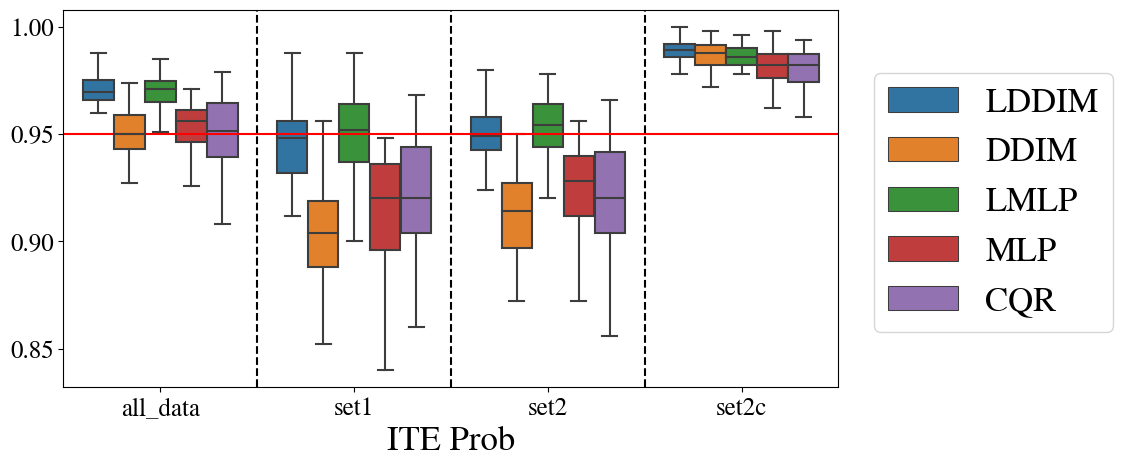

In [16]:
method_order=["LDDIM", "DDIM", "LMLP", "MLP", "CQR"]
sns.boxplot(data=all_res1, y="ITE", x="dataset", hue="method_raw", showfliers=False, hue_order=method_order, orient='v')
plt.axhline(y=0.95, color="red");
plt.ylabel("")
plt.xlabel("ITE Prob")
for s_ix in range(3):
    plt.axvline(x=s_ix+0.5, color="black", ls="--")
plt.legend(loc="lower center", bbox_to_anchor=(1.2, 0.1), ncol=1)

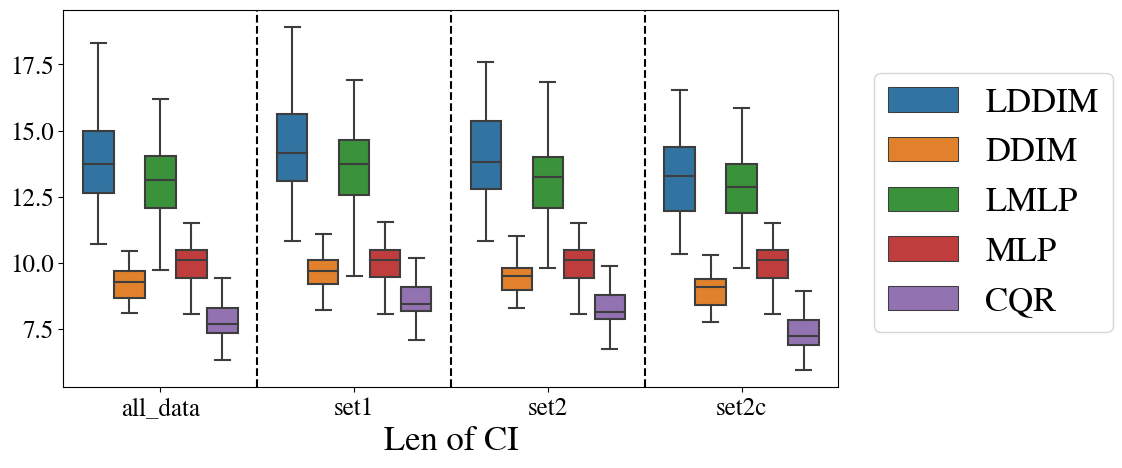

In [17]:
sns.boxplot(data=all_res1, y="Len", x="dataset", hue="method_raw", showfliers=False, hue_order=method_order, orient='v')
plt.ylabel("")
plt.xlabel("Len of CI");
for s_ix in range(3):
    plt.axvline(x=s_ix+0.5, color="black", ls="--")
plt.legend(loc="lower center", bbox_to_anchor=(1.2, 0.1), ncol=1)